In [1]:
!ls '/content/drive/MyDrive/Colab Notebooks/datasetBrain'

CroppedTesting	CroppedTraining  Testing  Training


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [9]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [10]:
INIT_LR = 1e-4
EPOCHS = 3
BS = 32

train_dir = '/content/drive/MyDrive/Colab Notebooks/datasetBrain/CroppedTraining'
CATEGORIES = ['no_tumor', 'yes_tumor']

In [11]:
data = []
labels = []

for cat in CATEGORIES:
  path = os.path.join(train_dir, cat)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(cat)

In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [14]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
baseModel = MobileNetV2(weights='imagenet', include_top=False,input_tensor=Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
for layer in baseModel.layers:
  layer.trainable = False

#print('[INFO] Compilando Model...')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) //BS,
    validation_data = (testX, testY),
    validation_steps=len(testX) //BS,
    epochs = EPOCHS
)

Epoch 1/3
40/40 [==============================] - 58s 1s/step - loss: 0.4163 - accuracy: 0.8759 - val_loss: 0.2975 - val_accuracy: 0.9164
Epoch 2/3
40/40 [==============================] - 52s 1s/step - loss: 0.3302 - accuracy: 0.9165 - val_loss: 0.2774 - val_accuracy: 0.9164
Epoch 3/3
40/40 [==============================] - 52s 1s/step - loss: 0.2894 - accuracy: 0.9125 - val_loss: 0.2738 - val_accuracy: 0.9164


In [19]:
print('[INFO] Evaluating networl')
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

print('[INFO] saving detector model')
model.save('tumor_detector.model', save_format='h5')

[INFO] Evaluating networl


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    no_tumor       0.92      1.00      0.96       296
   yes_tumor       0.00      0.00      0.00        27

    accuracy                           0.92       323
   macro avg       0.46      0.50      0.48       323
weighted avg       0.84      0.92      0.88       323

[INFO] saving detector model


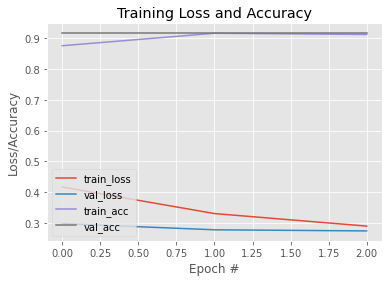

In [20]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label='val_acc')

plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('plot.png')

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import imutils
import time
import cv2
import os

[INFO] loading trained model for tumor classification


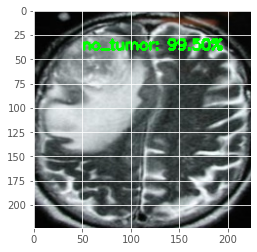

In [28]:
print('[INFO] loading trained model for tumor classification')
model = tf.keras.models.load_model('tumor_detector.model')
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/datasetBrain/CroppedTesting/yes_tumor/0.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(no_tumor, yes_tumor) = model.predict(img)[0]
label = 'no_tumor' if no_tumor > yes_tumor else 'yes_tumor'
color = (0,255,0) if no_tumor > yes_tumor else (0,0,255)
label = '{}: {:.2f}%'.format(label, max(no_tumor, yes_tumor) *100)
cv2.putText(image, label, (50, 50 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[INFO] loading trained model for tumor classification


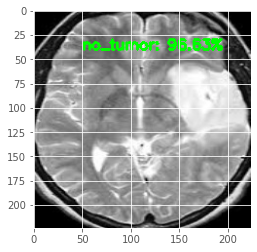

In [30]:
print('[INFO] loading trained model for tumor classification')
model = tf.keras.models.load_model('tumor_detector.model')
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/datasetBrain/CroppedTesting/yes_tumor/7.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(no_tumor, yes_tumor) = model.predict(img)[0]
label = 'no_tumor' if no_tumor > yes_tumor else 'yes_tumor'
color = (0,255,0) if no_tumor > yes_tumor else (0,0,255)
label = '{}: {:.2f}%'.format(label, max(no_tumor, yes_tumor) *100)
cv2.putText(image, label, (50, 50 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()